In [279]:
import datasets
from datasets import load_dataset
import numpy as np
import os
from PIL import Image, ImageDraw
from transformers import AutoImageProcessor
import albumentations
import numpy as np
import torch
from transformers import AutoModelForObjectDetection
from transformers import TrainingArguments

In [280]:
train_dataset = load_dataset("data/train", data_files="_annotations.coco.json")['train']
test_dataset = load_dataset("data/test", data_files="_annotations.coco.json")['train']
valid_dataset = load_dataset("data/valid", data_files="_annotations.coco.json")['train']

In [281]:
train_dataset

Dataset({
    features: ['info', 'licenses', 'categories', 'images', 'annotations'],
    num_rows: 1
})

In [282]:
test_dataset

Dataset({
    features: ['info', 'licenses', 'categories', 'images', 'annotations'],
    num_rows: 1
})

In [283]:
categories = {}
for i in range(len(train_dataset['categories'][0])):
    categories[train_dataset['categories'][0][i]['id']] = train_dataset['categories'][0][i]['name']
categories

{0: 'bikes-pedestrian',
 1: 'cyclist',
 2: 'e-scooter',
 3: 'motorcycle',
 4: 'person',
 5: 'vehicles'}

In [303]:
def make_dataset(dataset, path):
    images = []
    
    current_box = []
    current_areas = []
    current_category_ids = []
    current_ids = []

    image_id = 0    
    print('size =', len(dataset['annotations'][0]))
    for i in range(len(dataset['annotations'][0])): # len(train_dataset['annotations'][0])
        if i % 100 == 0:
            print(i)
        current = dataset['annotations'][0][i]
        if current['image_id'] != image_id:
            image = {}

            current_image = dataset['images'][0][image_id]            

            image['image_id'] = current_image['id']
            image['image'] = Image.open(f'data/{path}/{current_image["file_name"]}')
            image['height'] = current_image['height']
            image['width'] = current_image['width']
            
            temp = {}

            temp['id'] = current_ids
            temp['area'] = current_areas
            temp['bbox'] = current_box
            temp['category'] = current_category_ids

            image['objects'] = temp           

            current_box = []
            current_areas = []
            current_category_ids = []
            current_ids = []

            images += [image]

            image_id += 1

        current_box += [current['bbox']]
        current_areas += [current['area']]
        current_category_ids += [current['category_id']]
        current_ids += [current['id']]
    return images

In [ ]:
train = datasets.Dataset.from_list(make_dataset(train_dataset, 'train'))
test = datasets.Dataset.from_list(make_dataset(test_dataset, 'test'))
valid = datasets.Dataset.from_list(make_dataset(valid_dataset, 'valid'))

In [305]:
train

Dataset({
    features: ['image_id', 'image', 'height', 'width', 'objects'],
    num_rows: 5047
})

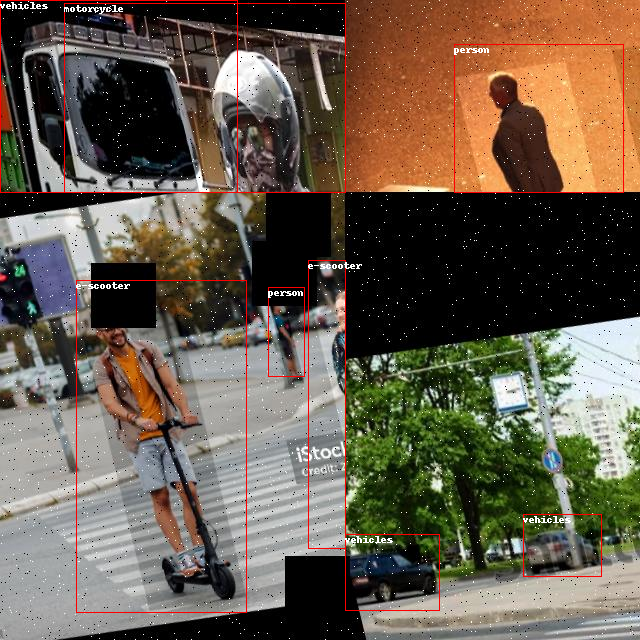

In [307]:
idx = 4

image = train[idx]["image"]
annotations = train[idx]["objects"]
draw = ImageDraw.Draw(image)


id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["area"])):
    box = annotations["bbox"][i]
    class_idx = annotations["category"][i]
    x, y, w, h = tuple(box)
    if max(box) > 1.0:
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), categories[class_idx], fill="white")

image

In [308]:
checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [309]:
transform = albumentations.Compose(
    [
        albumentations.Resize(256, 256)
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [310]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [311]:
train = train.with_transform(transform_aug_ann)

In [312]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [313]:
model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [314]:
training_args = TrainingArguments(
    output_dir='/output',
    per_device_train_batch_size=8,
    num_train_epochs=10,
    save_steps=200,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
)

In [315]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train,
    tokenizer=image_processor,
)

trainer.train()

  1%|          | 50/6310 [00:31<1:05:31,  1.59it/s]

{'loss': 2.9751, 'grad_norm': 251.1555633544922, 'learning_rate': 9.920760697305864e-06, 'epoch': 0.08}


  2%|▏         | 100/6310 [01:01<1:01:20,  1.69it/s]

{'loss': 2.7095, 'grad_norm': 69.6354751586914, 'learning_rate': 9.841521394611728e-06, 'epoch': 0.16}


  2%|▏         | 150/6310 [01:31<1:04:57,  1.58it/s]

{'loss': 2.4473, 'grad_norm': 63.969757080078125, 'learning_rate': 9.762282091917592e-06, 'epoch': 0.24}


  3%|▎         | 200/6310 [02:03<1:03:47,  1.60it/s]

{'loss': 2.2608, 'grad_norm': 113.02339935302734, 'learning_rate': 9.683042789223455e-06, 'epoch': 0.32}


  4%|▍         | 250/6310 [02:35<1:05:28,  1.54it/s]

{'loss': 2.2089, 'grad_norm': 39.5435905456543, 'learning_rate': 9.603803486529319e-06, 'epoch': 0.4}


  5%|▍         | 300/6310 [03:09<1:06:35,  1.50it/s]

{'loss': 2.106, 'grad_norm': 33.05017852783203, 'learning_rate': 9.524564183835183e-06, 'epoch': 0.48}


  6%|▌         | 350/6310 [03:42<1:05:35,  1.51it/s]

{'loss': 2.0742, 'grad_norm': 54.377750396728516, 'learning_rate': 9.445324881141046e-06, 'epoch': 0.55}


  6%|▋         | 400/6310 [04:15<1:02:43,  1.57it/s]

{'loss': 2.133, 'grad_norm': 132.2010040283203, 'learning_rate': 9.366085578446912e-06, 'epoch': 0.63}


  7%|▋         | 450/6310 [04:47<56:37,  1.72it/s]  

{'loss': 1.9756, 'grad_norm': 38.96211624145508, 'learning_rate': 9.286846275752775e-06, 'epoch': 0.71}


  8%|▊         | 500/6310 [05:19<1:02:07,  1.56it/s]

{'loss': 2.0, 'grad_norm': 31.445655822753906, 'learning_rate': 9.207606973058639e-06, 'epoch': 0.79}


  9%|▊         | 550/6310 [05:52<1:01:40,  1.56it/s]

{'loss': 1.9496, 'grad_norm': 39.38412094116211, 'learning_rate': 9.128367670364502e-06, 'epoch': 0.87}


 10%|▉         | 600/6310 [06:24<1:01:21,  1.55it/s]

{'loss': 2.0167, 'grad_norm': 106.72643280029297, 'learning_rate': 9.049128367670366e-06, 'epoch': 0.95}


 10%|█         | 650/6310 [06:57<59:59,  1.57it/s]  

{'loss': 1.9752, 'grad_norm': 213.16209411621094, 'learning_rate': 8.96988906497623e-06, 'epoch': 1.03}


 11%|█         | 700/6310 [07:29<1:02:44,  1.49it/s]

{'loss': 1.8712, 'grad_norm': 28.720407485961914, 'learning_rate': 8.890649762282093e-06, 'epoch': 1.11}


 12%|█▏        | 750/6310 [08:02<57:32,  1.61it/s]  

{'loss': 1.8335, 'grad_norm': 149.62030029296875, 'learning_rate': 8.811410459587957e-06, 'epoch': 1.19}


 13%|█▎        | 800/6310 [08:35<1:00:14,  1.52it/s]

{'loss': 1.8995, 'grad_norm': 191.2056121826172, 'learning_rate': 8.73217115689382e-06, 'epoch': 1.27}


 13%|█▎        | 850/6310 [09:08<1:00:01,  1.52it/s]

{'loss': 1.8431, 'grad_norm': 74.24175262451172, 'learning_rate': 8.652931854199684e-06, 'epoch': 1.35}


 14%|█▍        | 900/6310 [09:40<56:52,  1.59it/s]  

{'loss': 1.8706, 'grad_norm': 369.9079895019531, 'learning_rate': 8.573692551505548e-06, 'epoch': 1.43}


 15%|█▌        | 950/6310 [10:12<55:11,  1.62it/s]  

{'loss': 1.8017, 'grad_norm': 59.370155334472656, 'learning_rate': 8.494453248811411e-06, 'epoch': 1.51}


 16%|█▌        | 1000/6310 [10:45<57:15,  1.55it/s] 

{'loss': 1.8889, 'grad_norm': 49.53129959106445, 'learning_rate': 8.415213946117275e-06, 'epoch': 1.58}


 17%|█▋        | 1050/6310 [11:18<1:02:58,  1.39it/s]

{'loss': 1.7897, 'grad_norm': 57.522239685058594, 'learning_rate': 8.335974643423139e-06, 'epoch': 1.66}


 17%|█▋        | 1100/6310 [11:52<56:18,  1.54it/s]  

{'loss': 1.862, 'grad_norm': 138.1778564453125, 'learning_rate': 8.256735340729002e-06, 'epoch': 1.74}


 18%|█▊        | 1150/6310 [12:24<52:24,  1.64it/s]  

{'loss': 1.7687, 'grad_norm': 33.12592697143555, 'learning_rate': 8.177496038034866e-06, 'epoch': 1.82}


 19%|█▉        | 1200/6310 [12:56<53:21,  1.60it/s]

{'loss': 1.7799, 'grad_norm': 30.5257625579834, 'learning_rate': 8.09825673534073e-06, 'epoch': 1.9}


 20%|█▉        | 1250/6310 [13:29<55:42,  1.51it/s]  

{'loss': 1.7317, 'grad_norm': 62.860931396484375, 'learning_rate': 8.019017432646593e-06, 'epoch': 1.98}


 21%|██        | 1300/6310 [14:03<55:53,  1.49it/s]

{'loss': 1.8012, 'grad_norm': 330.3872375488281, 'learning_rate': 7.939778129952457e-06, 'epoch': 2.06}


 21%|██▏       | 1350/6310 [14:38<55:23,  1.49it/s]  

{'loss': 1.7515, 'grad_norm': 70.94254302978516, 'learning_rate': 7.86053882725832e-06, 'epoch': 2.14}


 22%|██▏       | 1400/6310 [15:12<54:00,  1.52it/s]

{'loss': 1.7508, 'grad_norm': 578.4594116210938, 'learning_rate': 7.781299524564184e-06, 'epoch': 2.22}


 23%|██▎       | 1450/6310 [15:46<48:52,  1.66it/s]  

{'loss': 1.6858, 'grad_norm': 34.83462142944336, 'learning_rate': 7.702060221870048e-06, 'epoch': 2.3}


 24%|██▍       | 1500/6310 [16:20<54:22,  1.47it/s]

{'loss': 1.6909, 'grad_norm': 39.359500885009766, 'learning_rate': 7.622820919175912e-06, 'epoch': 2.38}


 25%|██▍       | 1550/6310 [16:53<48:46,  1.63it/s]

{'loss': 1.7589, 'grad_norm': 146.03402709960938, 'learning_rate': 7.543581616481776e-06, 'epoch': 2.46}


 25%|██▌       | 1600/6310 [17:24<48:55,  1.60it/s]

{'loss': 1.6571, 'grad_norm': 33.69366455078125, 'learning_rate': 7.464342313787639e-06, 'epoch': 2.54}


 26%|██▌       | 1650/6310 [17:55<46:44,  1.66it/s]

{'loss': 1.7459, 'grad_norm': 60.03001403808594, 'learning_rate': 7.385103011093503e-06, 'epoch': 2.61}


 27%|██▋       | 1700/6310 [18:28<51:50,  1.48it/s]

{'loss': 1.6112, 'grad_norm': 59.881263732910156, 'learning_rate': 7.305863708399367e-06, 'epoch': 2.69}


 28%|██▊       | 1750/6310 [19:01<53:02,  1.43it/s]

{'loss': 1.6151, 'grad_norm': 47.1949577331543, 'learning_rate': 7.22662440570523e-06, 'epoch': 2.77}


 29%|██▊       | 1800/6310 [19:34<51:12,  1.47it/s]

{'loss': 1.5869, 'grad_norm': 48.96318054199219, 'learning_rate': 7.147385103011094e-06, 'epoch': 2.85}


 29%|██▉       | 1850/6310 [20:07<49:47,  1.49it/s]  

{'loss': 1.6546, 'grad_norm': 27.652854919433594, 'learning_rate': 7.0681458003169574e-06, 'epoch': 2.93}


 30%|███       | 1900/6310 [20:39<46:59,  1.56it/s]

{'loss': 1.5774, 'grad_norm': 22.281909942626953, 'learning_rate': 6.988906497622822e-06, 'epoch': 3.01}


 31%|███       | 1950/6310 [21:11<45:33,  1.60it/s]

{'loss': 1.5552, 'grad_norm': 51.14557647705078, 'learning_rate': 6.9096671949286855e-06, 'epoch': 3.09}


 32%|███▏      | 2000/6310 [21:43<44:24,  1.62it/s]

{'loss': 1.5585, 'grad_norm': 46.936431884765625, 'learning_rate': 6.830427892234549e-06, 'epoch': 3.17}


 32%|███▏      | 2050/6310 [22:15<44:10,  1.61it/s]

{'loss': 1.5751, 'grad_norm': 46.100154876708984, 'learning_rate': 6.751188589540413e-06, 'epoch': 3.25}


 33%|███▎      | 2100/6310 [22:46<43:36,  1.61it/s]

{'loss': 1.5648, 'grad_norm': 83.26329040527344, 'learning_rate': 6.671949286846276e-06, 'epoch': 3.33}


 34%|███▍      | 2150/6310 [23:18<43:06,  1.61it/s]

{'loss': 1.5873, 'grad_norm': 35.21509552001953, 'learning_rate': 6.59270998415214e-06, 'epoch': 3.41}


 35%|███▍      | 2200/6310 [23:50<43:42,  1.57it/s]

{'loss': 1.5327, 'grad_norm': 26.15750503540039, 'learning_rate': 6.513470681458004e-06, 'epoch': 3.49}


 36%|███▌      | 2250/6310 [24:22<42:45,  1.58it/s]

{'loss': 1.604, 'grad_norm': 48.150657653808594, 'learning_rate': 6.434231378763868e-06, 'epoch': 3.57}


 36%|███▋      | 2300/6310 [24:54<42:10,  1.58it/s]

{'loss': 1.5515, 'grad_norm': 156.38217163085938, 'learning_rate': 6.354992076069732e-06, 'epoch': 3.65}


 37%|███▋      | 2350/6310 [25:26<41:25,  1.59it/s]

{'loss': 1.5941, 'grad_norm': 434.0567626953125, 'learning_rate': 6.275752773375595e-06, 'epoch': 3.72}


 38%|███▊      | 2400/6310 [25:58<41:43,  1.56it/s]

{'loss': 1.5851, 'grad_norm': 35.015933990478516, 'learning_rate': 6.196513470681459e-06, 'epoch': 3.8}


 39%|███▉      | 2450/6310 [26:31<42:24,  1.52it/s]

{'loss': 1.5407, 'grad_norm': 28.732690811157227, 'learning_rate': 6.117274167987323e-06, 'epoch': 3.88}


 40%|███▉      | 2500/6310 [27:03<42:27,  1.50it/s]

{'loss': 1.5588, 'grad_norm': 50.99106979370117, 'learning_rate': 6.038034865293186e-06, 'epoch': 3.96}


 40%|████      | 2550/6310 [27:36<40:01,  1.57it/s]

{'loss': 1.5662, 'grad_norm': 57.08902359008789, 'learning_rate': 5.95879556259905e-06, 'epoch': 4.04}


 41%|████      | 2600/6310 [28:08<39:45,  1.56it/s]

{'loss': 1.5278, 'grad_norm': 34.84254455566406, 'learning_rate': 5.8795562599049135e-06, 'epoch': 4.12}


 42%|████▏     | 2650/6310 [28:40<38:18,  1.59it/s]

{'loss': 1.4839, 'grad_norm': 36.856685638427734, 'learning_rate': 5.800316957210776e-06, 'epoch': 4.2}


 43%|████▎     | 2700/6310 [29:12<39:13,  1.53it/s]

{'loss': 1.5036, 'grad_norm': 34.57667922973633, 'learning_rate': 5.72107765451664e-06, 'epoch': 4.28}


 44%|████▎     | 2750/6310 [29:44<38:26,  1.54it/s]

{'loss': 1.4628, 'grad_norm': 60.23811340332031, 'learning_rate': 5.6418383518225035e-06, 'epoch': 4.36}


 44%|████▍     | 2800/6310 [30:17<37:35,  1.56it/s]

{'loss': 1.5461, 'grad_norm': 78.57608795166016, 'learning_rate': 5.562599049128368e-06, 'epoch': 4.44}


 45%|████▌     | 2850/6310 [30:50<35:51,  1.61it/s]

{'loss': 1.5169, 'grad_norm': 111.39958953857422, 'learning_rate': 5.483359746434232e-06, 'epoch': 4.52}


 46%|████▌     | 2900/6310 [31:22<36:00,  1.58it/s]

{'loss': 1.4448, 'grad_norm': 28.769359588623047, 'learning_rate': 5.404120443740095e-06, 'epoch': 4.6}


 47%|████▋     | 2950/6310 [31:55<37:57,  1.48it/s]

{'loss': 1.4509, 'grad_norm': 163.46414184570312, 'learning_rate': 5.324881141045959e-06, 'epoch': 4.68}


 48%|████▊     | 3000/6310 [32:28<34:39,  1.59it/s]

{'loss': 1.4733, 'grad_norm': 25.602928161621094, 'learning_rate': 5.2456418383518225e-06, 'epoch': 4.75}


 48%|████▊     | 3050/6310 [33:00<36:33,  1.49it/s]

{'loss': 1.5055, 'grad_norm': 59.35973358154297, 'learning_rate': 5.166402535657686e-06, 'epoch': 4.83}


 49%|████▉     | 3100/6310 [33:32<35:06,  1.52it/s]

{'loss': 1.4933, 'grad_norm': 98.08079528808594, 'learning_rate': 5.08716323296355e-06, 'epoch': 4.91}


 50%|████▉     | 3150/6310 [34:04<35:29,  1.48it/s]

{'loss': 1.4894, 'grad_norm': 86.84492492675781, 'learning_rate': 5.007923930269414e-06, 'epoch': 4.99}


 51%|█████     | 3200/6310 [34:36<33:30,  1.55it/s]

{'loss': 1.4405, 'grad_norm': 96.4920425415039, 'learning_rate': 4.928684627575278e-06, 'epoch': 5.07}


 52%|█████▏    | 3250/6310 [35:09<32:10,  1.58it/s]

{'loss': 1.4516, 'grad_norm': 51.19983673095703, 'learning_rate': 4.8494453248811415e-06, 'epoch': 5.15}


 52%|█████▏    | 3300/6310 [35:41<31:52,  1.57it/s]

{'loss': 1.4767, 'grad_norm': 72.62672424316406, 'learning_rate': 4.770206022187005e-06, 'epoch': 5.23}


 53%|█████▎    | 3350/6310 [36:14<33:06,  1.49it/s]

{'loss': 1.4719, 'grad_norm': 21.99674415588379, 'learning_rate': 4.690966719492869e-06, 'epoch': 5.31}


 54%|█████▍    | 3400/6310 [36:46<30:56,  1.57it/s]

{'loss': 1.4193, 'grad_norm': 30.33940887451172, 'learning_rate': 4.611727416798732e-06, 'epoch': 5.39}


 55%|█████▍    | 3450/6310 [37:18<30:02,  1.59it/s]

{'loss': 1.4351, 'grad_norm': 28.380794525146484, 'learning_rate': 4.532488114104596e-06, 'epoch': 5.47}


 55%|█████▌    | 3500/6310 [37:50<29:20,  1.60it/s]

{'loss': 1.4229, 'grad_norm': 86.40875244140625, 'learning_rate': 4.45324881141046e-06, 'epoch': 5.55}


 56%|█████▋    | 3550/6310 [38:22<29:06,  1.58it/s]

{'loss': 1.4491, 'grad_norm': 54.870548248291016, 'learning_rate': 4.374009508716324e-06, 'epoch': 5.63}


 57%|█████▋    | 3600/6310 [38:54<28:42,  1.57it/s]

{'loss': 1.4749, 'grad_norm': 51.42998504638672, 'learning_rate': 4.294770206022188e-06, 'epoch': 5.71}


 58%|█████▊    | 3650/6310 [39:27<28:31,  1.55it/s]

{'loss': 1.4318, 'grad_norm': 30.461158752441406, 'learning_rate': 4.215530903328051e-06, 'epoch': 5.78}


 59%|█████▊    | 3700/6310 [39:58<28:15,  1.54it/s]

{'loss': 1.4006, 'grad_norm': 35.94508361816406, 'learning_rate': 4.136291600633915e-06, 'epoch': 5.86}


 59%|█████▉    | 3750/6310 [40:32<28:25,  1.50it/s]

{'loss': 1.372, 'grad_norm': 89.04361724853516, 'learning_rate': 4.0570522979397786e-06, 'epoch': 5.94}


 60%|██████    | 3800/6310 [41:04<27:35,  1.52it/s]

{'loss': 1.4123, 'grad_norm': 64.04096984863281, 'learning_rate': 3.977812995245642e-06, 'epoch': 6.02}


 61%|██████    | 3850/6310 [41:37<26:28,  1.55it/s]

{'loss': 1.3931, 'grad_norm': 20.39325523376465, 'learning_rate': 3.898573692551506e-06, 'epoch': 6.1}


 62%|██████▏   | 3900/6310 [42:08<25:27,  1.58it/s]

{'loss': 1.3988, 'grad_norm': 31.615447998046875, 'learning_rate': 3.8193343898573694e-06, 'epoch': 6.18}


 63%|██████▎   | 3950/6310 [42:40<24:45,  1.59it/s]

{'loss': 1.3868, 'grad_norm': 39.856605529785156, 'learning_rate': 3.740095087163233e-06, 'epoch': 6.26}


 63%|██████▎   | 4000/6310 [43:12<23:50,  1.62it/s]

{'loss': 1.3945, 'grad_norm': 21.44904136657715, 'learning_rate': 3.6608557844690967e-06, 'epoch': 6.34}


 64%|██████▍   | 4050/6310 [43:44<23:44,  1.59it/s]

{'loss': 1.4132, 'grad_norm': 117.003173828125, 'learning_rate': 3.5816164817749603e-06, 'epoch': 6.42}


 65%|██████▍   | 4100/6310 [44:17<23:50,  1.54it/s]

{'loss': 1.3558, 'grad_norm': 89.29388427734375, 'learning_rate': 3.5023771790808243e-06, 'epoch': 6.5}


 66%|██████▌   | 4150/6310 [44:49<22:28,  1.60it/s]

{'loss': 1.3536, 'grad_norm': 40.12176513671875, 'learning_rate': 3.423137876386688e-06, 'epoch': 6.58}


 67%|██████▋   | 4200/6310 [45:22<22:26,  1.57it/s]

{'loss': 1.3492, 'grad_norm': 37.51625442504883, 'learning_rate': 3.3438985736925516e-06, 'epoch': 6.66}


 67%|██████▋   | 4250/6310 [45:54<21:43,  1.58it/s]

{'loss': 1.3973, 'grad_norm': 36.90180969238281, 'learning_rate': 3.2646592709984152e-06, 'epoch': 6.74}


 68%|██████▊   | 4300/6310 [46:26<20:59,  1.60it/s]

{'loss': 1.4203, 'grad_norm': 25.11741065979004, 'learning_rate': 3.1854199683042793e-06, 'epoch': 6.81}


 69%|██████▉   | 4350/6310 [46:58<20:45,  1.57it/s]

{'loss': 1.3959, 'grad_norm': 27.047956466674805, 'learning_rate': 3.106180665610143e-06, 'epoch': 6.89}


 70%|██████▉   | 4400/6310 [47:30<20:39,  1.54it/s]

{'loss': 1.3645, 'grad_norm': 90.62157440185547, 'learning_rate': 3.0269413629160065e-06, 'epoch': 6.97}


 71%|███████   | 4450/6310 [48:02<20:32,  1.51it/s]

{'loss': 1.325, 'grad_norm': 69.01649475097656, 'learning_rate': 2.94770206022187e-06, 'epoch': 7.05}


 71%|███████▏  | 4500/6310 [48:34<20:58,  1.44it/s]

{'loss': 1.334, 'grad_norm': 34.99060821533203, 'learning_rate': 2.868462757527734e-06, 'epoch': 7.13}


 72%|███████▏  | 4550/6310 [49:07<19:18,  1.52it/s]

{'loss': 1.3362, 'grad_norm': 118.46402740478516, 'learning_rate': 2.789223454833598e-06, 'epoch': 7.21}


 73%|███████▎  | 4600/6310 [49:38<17:42,  1.61it/s]

{'loss': 1.3133, 'grad_norm': 46.5585823059082, 'learning_rate': 2.7099841521394614e-06, 'epoch': 7.29}


 74%|███████▎  | 4650/6310 [50:11<17:19,  1.60it/s]

{'loss': 1.317, 'grad_norm': 54.29016876220703, 'learning_rate': 2.630744849445325e-06, 'epoch': 7.37}


 74%|███████▍  | 4700/6310 [50:43<17:23,  1.54it/s]

{'loss': 1.3355, 'grad_norm': 54.70338439941406, 'learning_rate': 2.551505546751189e-06, 'epoch': 7.45}


 75%|███████▌  | 4750/6310 [51:16<17:19,  1.50it/s]

{'loss': 1.3513, 'grad_norm': 24.222198486328125, 'learning_rate': 2.4722662440570523e-06, 'epoch': 7.53}


 76%|███████▌  | 4800/6310 [51:48<16:27,  1.53it/s]

{'loss': 1.3561, 'grad_norm': 19.238800048828125, 'learning_rate': 2.3930269413629164e-06, 'epoch': 7.61}


 77%|███████▋  | 4850/6310 [52:21<15:19,  1.59it/s]

{'loss': 1.3213, 'grad_norm': 67.8681411743164, 'learning_rate': 2.31378763866878e-06, 'epoch': 7.69}


 78%|███████▊  | 4900/6310 [52:54<14:57,  1.57it/s]

{'loss': 1.3454, 'grad_norm': 39.03535079956055, 'learning_rate': 2.2345483359746436e-06, 'epoch': 7.77}


 78%|███████▊  | 4950/6310 [53:26<14:48,  1.53it/s]

{'loss': 1.3545, 'grad_norm': 24.778581619262695, 'learning_rate': 2.1553090332805072e-06, 'epoch': 7.84}


 79%|███████▉  | 5000/6310 [53:59<14:10,  1.54it/s]

{'loss': 1.336, 'grad_norm': 58.16328430175781, 'learning_rate': 2.0760697305863713e-06, 'epoch': 7.92}


 80%|████████  | 5050/6310 [54:32<14:55,  1.41it/s]

{'loss': 1.3524, 'grad_norm': 32.38496398925781, 'learning_rate': 1.9968304278922345e-06, 'epoch': 8.0}


 81%|████████  | 5100/6310 [55:06<13:13,  1.53it/s]

{'loss': 1.3205, 'grad_norm': 53.61500930786133, 'learning_rate': 1.9175911251980985e-06, 'epoch': 8.08}


 82%|████████▏ | 5150/6310 [55:39<12:38,  1.53it/s]

{'loss': 1.318, 'grad_norm': 21.21076202392578, 'learning_rate': 1.8383518225039621e-06, 'epoch': 8.16}


 82%|████████▏ | 5200/6310 [56:12<12:25,  1.49it/s]

{'loss': 1.3565, 'grad_norm': 33.70733642578125, 'learning_rate': 1.7591125198098258e-06, 'epoch': 8.24}


 83%|████████▎ | 5250/6310 [56:45<11:06,  1.59it/s]

{'loss': 1.4049, 'grad_norm': 37.250755310058594, 'learning_rate': 1.6798732171156896e-06, 'epoch': 8.32}


 84%|████████▍ | 5300/6310 [57:19<10:59,  1.53it/s]

{'loss': 1.238, 'grad_norm': 32.878726959228516, 'learning_rate': 1.6006339144215532e-06, 'epoch': 8.4}


 85%|████████▍ | 5350/6310 [57:50<10:00,  1.60it/s]

{'loss': 1.2655, 'grad_norm': 51.25165939331055, 'learning_rate': 1.521394611727417e-06, 'epoch': 8.48}


 86%|████████▌ | 5400/6310 [58:22<09:46,  1.55it/s]

{'loss': 1.3234, 'grad_norm': 33.52538299560547, 'learning_rate': 1.4421553090332807e-06, 'epoch': 8.56}


 86%|████████▋ | 5450/6310 [58:55<09:10,  1.56it/s]

{'loss': 1.274, 'grad_norm': 38.97233581542969, 'learning_rate': 1.3629160063391445e-06, 'epoch': 8.64}


 87%|████████▋ | 5500/6310 [59:27<08:30,  1.59it/s]

{'loss': 1.3295, 'grad_norm': 32.42499923706055, 'learning_rate': 1.283676703645008e-06, 'epoch': 8.72}


 88%|████████▊ | 5550/6310 [59:59<08:23,  1.51it/s]

{'loss': 1.3689, 'grad_norm': 23.544992446899414, 'learning_rate': 1.2044374009508718e-06, 'epoch': 8.8}


 89%|████████▊ | 5600/6310 [1:00:32<07:25,  1.60it/s]

{'loss': 1.3469, 'grad_norm': 22.884469985961914, 'learning_rate': 1.1251980982567354e-06, 'epoch': 8.87}


 90%|████████▉ | 5650/6310 [1:01:05<07:18,  1.50it/s]

{'loss': 1.2742, 'grad_norm': 77.15788269042969, 'learning_rate': 1.045958795562599e-06, 'epoch': 8.95}


 90%|█████████ | 5700/6310 [1:01:38<06:33,  1.55it/s]

{'loss': 1.2745, 'grad_norm': 45.743621826171875, 'learning_rate': 9.667194928684629e-07, 'epoch': 9.03}


 91%|█████████ | 5750/6310 [1:02:10<05:56,  1.57it/s]

{'loss': 1.308, 'grad_norm': 22.010414123535156, 'learning_rate': 8.874801901743266e-07, 'epoch': 9.11}


 92%|█████████▏| 5800/6310 [1:02:42<05:24,  1.57it/s]

{'loss': 1.3002, 'grad_norm': 25.130136489868164, 'learning_rate': 8.082408874801903e-07, 'epoch': 9.19}


 93%|█████████▎| 5850/6310 [1:03:15<05:10,  1.48it/s]

{'loss': 1.2767, 'grad_norm': 34.46512985229492, 'learning_rate': 7.290015847860539e-07, 'epoch': 9.27}


 94%|█████████▎| 5900/6310 [1:03:49<04:24,  1.55it/s]

{'loss': 1.2701, 'grad_norm': 26.12123680114746, 'learning_rate': 6.497622820919177e-07, 'epoch': 9.35}


 94%|█████████▍| 5950/6310 [1:04:22<03:52,  1.55it/s]

{'loss': 1.3283, 'grad_norm': 56.613407135009766, 'learning_rate': 5.705229793977814e-07, 'epoch': 9.43}


 95%|█████████▌| 6000/6310 [1:04:56<03:22,  1.53it/s]

{'loss': 1.2466, 'grad_norm': 23.49321174621582, 'learning_rate': 4.91283676703645e-07, 'epoch': 9.51}


 96%|█████████▌| 6050/6310 [1:05:30<02:55,  1.48it/s]

{'loss': 1.2697, 'grad_norm': 34.32322692871094, 'learning_rate': 4.1204437400950875e-07, 'epoch': 9.59}


 97%|█████████▋| 6100/6310 [1:06:04<02:23,  1.46it/s]

{'loss': 1.3214, 'grad_norm': 34.20560073852539, 'learning_rate': 3.3280507131537243e-07, 'epoch': 9.67}


 97%|█████████▋| 6150/6310 [1:06:37<01:44,  1.53it/s]

{'loss': 1.2973, 'grad_norm': 34.44208908081055, 'learning_rate': 2.5356576862123616e-07, 'epoch': 9.75}


 98%|█████████▊| 6200/6310 [1:07:11<01:14,  1.48it/s]

{'loss': 1.2656, 'grad_norm': 28.002323150634766, 'learning_rate': 1.7432646592709986e-07, 'epoch': 9.83}


 99%|█████████▉| 6250/6310 [1:07:45<00:41,  1.46it/s]

{'loss': 1.2766, 'grad_norm': 65.26901245117188, 'learning_rate': 9.508716323296357e-08, 'epoch': 9.9}


100%|█████████▉| 6300/6310 [1:08:18<00:06,  1.49it/s]

{'loss': 1.3523, 'grad_norm': 36.64072036743164, 'learning_rate': 1.584786053882726e-08, 'epoch': 9.98}


100%|██████████| 6310/6310 [1:08:25<00:00,  1.54it/s]

{'train_runtime': 4105.2875, 'train_samples_per_second': 12.294, 'train_steps_per_second': 1.537, 'train_loss': 1.556743329224987, 'epoch': 10.0}


TrainOutput(global_step=6310, training_loss=1.556743329224987, metrics={'train_runtime': 4105.2875, 'train_samples_per_second': 12.294, 'train_steps_per_second': 1.537, 'train_loss': 1.556743329224987, 'epoch': 10.0})

In [316]:
import json

def val_formatted_anns(image_id, objects):
    annotations = []
    for i in range(0, len(objects["id"])):
        new_ann = {
            "id": objects["id"][i],
            "category_id": objects["category"][i],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][i],
            "bbox": objects["bbox"][i],
        }
        annotations.append(new_ann)

    return annotations

def save_cppe5_annotation_file_images(cppe5):
    output_json = {}
    path_output_cppe5 = f"{os.getcwd()}/cppe5/"

    if not os.path.exists(path_output_cppe5):
        os.makedirs(path_output_cppe5)

    path_anno = os.path.join(path_output_cppe5, "cppe5_ann.json")
    categories_json = [{"supercategory": "none", "id": id, "name": id2label[id]} for id in id2label]
    output_json["images"] = []
    output_json["annotations"] = []
    for example in cppe5:
        ann = val_formatted_anns(example["image_id"], example["objects"])
        output_json["images"].append(
            {
                "id": example["image_id"],
                "width": example["image"].width,
                "height": example["image"].height,
                "file_name": f"{example['image_id']}.png",
            }
        )
        output_json["annotations"].extend(ann)
    output_json["categories"] = categories_json

    with open(path_anno, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    for im, img_id in zip(cppe5["image"], cppe5["image_id"]):
        path_img = os.path.join(path_output_cppe5, f"{img_id}.png")
        im.save(path_img)

    return path_output_cppe5, path_anno

In [317]:
import torchvision

In [318]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, image_processor, ann_file):
        super().__init__(img_folder, ann_file)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target: converting target to DETR format,
        # resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        encoding = self.image_processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension

        return {"pixel_values": pixel_values, "labels": target}


im_processor = AutoImageProcessor.from_pretrained("devonho/detr-resnet-50_finetuned_cppe5")

path_output_cppe5, path_anno = save_cppe5_annotation_file_images(test)
test_ds_coco_format = CocoDetection(path_output_cppe5, im_processor, path_anno)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [319]:
import evaluate
from tqdm import tqdm

model = AutoModelForObjectDetection.from_pretrained("devonho/detr-resnet-50_finetuned_cppe5")
module = evaluate.load("ybelkada/cocoevaluate", coco=test_ds_coco_format.coco)
val_dataloader = torch.utils.data.DataLoader(
    test_ds_coco_format, batch_size=3, shuffle=False, num_workers=0, collate_fn=collate_fn
)

with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]  # these are in DETR format, resized + normalized

        # forward pass
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = im_processor.post_process(outputs, orig_target_sizes)

        module.add(prediction=results, reference=labels)
        del batch

results = module.compute()
print(results)

Some weights of the model checkpoint at devonho/detr-resnet-50_finetuned_cppe5 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 80/80 [01:50<00:00,  1.38s/it]


Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.029
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.033
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [343]:
train[0]

{'pixel_values': tensor([[[-1.7240, -1.7240, -1.7069,  ..., -2.0665, -2.0665, -2.0665],
          [-1.7240, -1.7240, -1.7069,  ..., -2.0665, -2.0665, -2.0665],
          [-1.7412, -1.7412, -1.7240,  ..., -2.0665, -2.0665, -2.0665],
          ...,
          [-1.6042, -1.6042, -1.6384,  ..., -1.8268, -1.7412, -1.7412],
          [-1.6213, -1.6213, -1.6384,  ..., -1.9467, -1.9295, -1.9295],
          [-1.6213, -1.6213, -1.6384,  ..., -1.9467, -1.9295, -1.9295]],
 
         [[-1.5280, -1.5280, -1.5105,  ..., -1.8957, -1.8957, -1.8957],
          [-1.5280, -1.5280, -1.5105,  ..., -1.8957, -1.8957, -1.8957],
          [-1.5455, -1.5455, -1.5280,  ..., -1.8957, -1.8957, -1.8957],
          ...,
          [-1.2479, -1.2479, -1.2654,  ..., -1.7381, -1.6506, -1.6506],
          [-1.2654, -1.2654, -1.2829,  ..., -1.8606, -1.8431, -1.8431],
          [-1.2654, -1.2654, -1.2829,  ..., -1.8606, -1.8431, -1.8431]],
 
         [[-1.2119, -1.2119, -1.1944,  ..., -1.6824, -1.6824, -1.6824],
          [-

Detected bikes-pedestrian with confidence 0.623 at location [337.26, 291.4, 456.17, 479.25]


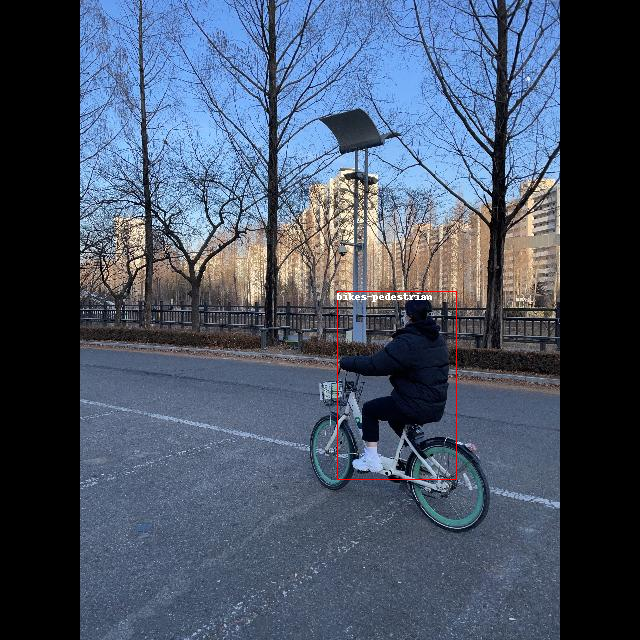

In [363]:
idx = 0
image = Image.open('data/test/' + test_dataset['images'][0][idx]["file_name"])
with torch.no_grad():
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {categories[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), categories[label.item()], fill="white")

image